In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

Define Preprocessing Steps, We use the ColumnTransformer class to bundle together different preprocessing steps. The code:

-> imputes missing values in numerical data, and
-> imputes missing values and applies a one-hot encoding to categorical data.

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


Define the Model

In [3]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

Create and Evaluate Pipleline

In [4]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 177453.58753804347


#### When to Use Cross Validation?
For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.
For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.

In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.

For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that we have broken the data into 5 "folds".

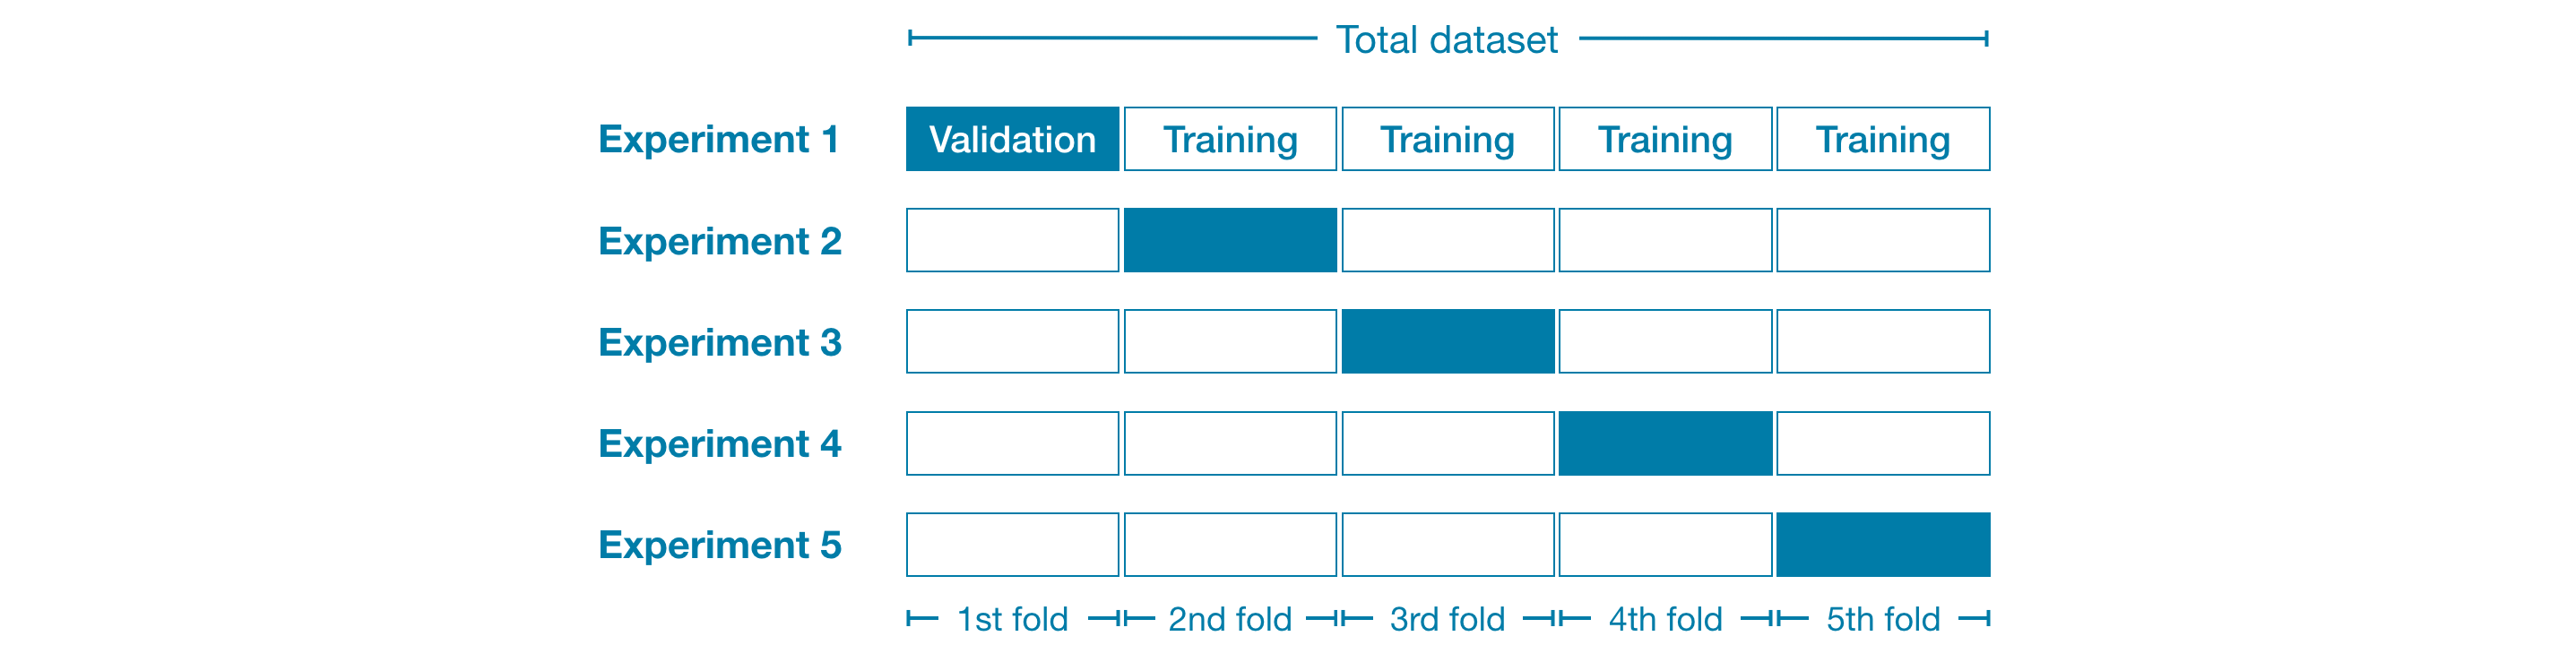

In [5]:
# Read the data
data = pd.read_csv('melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price

#Can also build pipeline in this simpler approach
cv_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])

In [7]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(cv_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print("Average MAE score (across experiments):")
print(scores.mean())

MAE scores:
 [330153.84614038 315703.21408613 299410.61884391 243541.74763508
 251301.76683685]
Average MAE score (across experiments):
288022.23870846874
